### Imports

In [1]:
import datetime
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import sys

from time import time
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

### Upload data

In [2]:
#Setting correct path 
cwd = os.getcwd() # Get current working directory
root_folder = os.sep + "ML-Neuron-Classification"
sys.path.insert(0, cwd[:(cwd.index(root_folder)+len(root_folder))] + os.sep)
from utils.helper_functions import*
from utils.unpacking_dat_files import*

nmi = normalized_mutual_info_score
ari = adjusted_rand_score
date = datetime.date.today()

#Upload data
data_path = 'C:/Users/Marius/Documents/Datasets/.txt/ec014.42_794_796_798_spikes.txt'
x = np.genfromtxt(data_path, usecols=list(range(0,256)), skip_header=1)
parameters = np.genfromtxt(data_path, dtype=None, encoding='UTF-8', usecols=list(range(256,267)), skip_header=1)

### Preprocessing

In [3]:
#Include paramter information into main array
classification = np.empty(shape=(x.shape[0],1))
for i in range(0, x.shape[0]):
  if parameters[i][8] != 0 and parameters[i][9] == 0: #excitatory
    classification[i] = 0
  elif parameters[i][8] == 0 and parameters[i][9] != 0: #inhibitory
    classification[i] = 1
  else:
    classification[i] = 2 #neither
  i=i+1
x = np.append(x, classification, axis=1)
x = x[x[:,256] != 2] #No neither

excits = x[x[:,256] == 0]
inhibs = x[x[:,256] == 1]
print("#Excting traces:", excits.shape[0])


rnd = np.random.choice(inhibs.shape[0], excits.shape[0], replace=False) #As more inhibs, choose randomly from inhibibitory to get same number of both types
inhibs = inhibs[rnd,:]
print("#Inhibiting traces:", inhibs.shape[0])
x = np.concatenate([excits, inhibs], axis=0) #back together
x = np.take(x,np.random.permutation(x.shape[0]),axis=0,out=x) #random shuffle
print("#Total traces:", x.shape[0])

Y_train = x[:,256]
X = x[:,:-1]

X_train = normalization_train(X)

print('Self-training with', X_train.shape[0], 'traces!')
n_clusters = len(np.unique(Y_train))
print(np.unique(Y_train))
print(n_clusters)

#Excting traces: 13155
#Inhibiting traces: 13155
#Total traces: 26310
Self-training with 26310 traces!
[0. 1.]
2


In [8]:
#Hyperparameters
dims = [X_train.shape[-1], 500, 500, 2000, 7]
k_means = []
#init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = 'Adam'
pretrain_epochs = 50
batch_size = 64
save_dir = 'C:/Users/Marius/Documents/GitHub/ML-Neuron-Classification/Unsupervised learning/Model weights'

for i in range (20):
    def autoencoder(dims, act='relu', init='glorot_uniform'):
	    n_stacks = len(dims) - 1
	    # input
	    input_img = Input(shape=(dims[0],), name='input')
	    x = input_img
	    # internal layers in encoder
	    for i in range(n_stacks-1):
	        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

	    # hidden layer
	    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

	    x = encoded
	    # internal layers in decoder
	    for i in range(n_stacks-1, 0, -1):
	        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

	    # output
	    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
	    decoded = x
	    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')
    autoencoder, encoder = autoencoder(dims)
    autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
    name_save_process = f'/2020-10-19_DEC_{pretrain_epochs}epochs_{i}_pretrain.h5'
    name_save_final = f'/2020-10-19_DEC_{pretrain_epochs}epochs_{i}_final.h5'
    autoencoder.load_weights(save_dir + name_save_process)
    #Clustering
    clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
    model = Model(inputs=encoder.input, outputs=clustering_layer)
    model.compile(optimizer='Adam', loss='kld')

    #Initialize Clusters using K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    y_pred = kmeans.fit_predict(encoder.predict(X_train))
    y_pred_last = np.copy(y_pred)
    model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
    print(acc(Y_train, y_pred))
    k_means = np.append(k_means, acc(Y_train, y_pred))

print(k_means)

0.8979475484606614
0.9072215887495249
0.9127708095781072
0.9047890535917902
0.8976434815659445
0.8669327251995439
0.9155454199923984
0.8988217407829723
0.9253515773470163
0.9130368681109844
0.9144051691372101
0.9242873432155074
0.911250475104523
0.9055492208285822
0.8952489547700494
0.865488407449639
0.9093120486507031
0.9052451539338654
0.8836944127708096
0.9136830102622577
[0.89794755 0.90722159 0.91277081 0.90478905 0.89764348 0.86693273
 0.91554542 0.89882174 0.92535158 0.91303687 0.91440517 0.92428734
 0.91125048 0.90554922 0.89524895 0.86548841 0.90931205 0.90524515
 0.88369441 0.91368301]


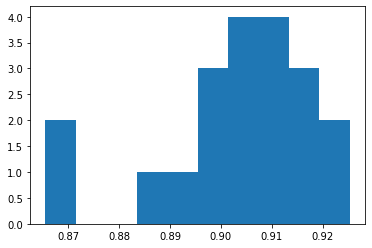

In [13]:
plt.hist(k_means)
plt.show()

### Hyperparameter

In [27]:
#Hyperparameters
dims = [X_train.shape[-1], 500, 500, 2000, 7]
#init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = 'Adam'
pretrain_epochs = 50
batch_size = 64
save_dir = 'C:/Users/Marius/Documents/GitHub/ML-Neuron-Classification/Unsupervised learning/Model weights'
name_save_process = f'/{date}_DEC_{pretrain_epochs}epochs_pretrain_1.h5'
name_save_final = f'/{date}_DEC_{pretrain_epochs}epochs_final_1.h5'

### Pre-training

In [28]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir + name_save_process)

Train on 26310 samples
Epoch 1/50
26310/26310 [==============================] - 15s 568us/sample - loss: 1.7863e-04
Epoch 2/50
26310/26310 [==============================] - 15s 555us/sample - loss: 1.2501e-04
Epoch 3/50
26310/26310 [==============================] - 15s 567us/sample - loss: 1.1417e-04
Epoch 4/50
26310/26310 [==============================] - 15s 574us/sample - loss: 1.1225e-04
Epoch 5/50
26310/26310 [==============================] - 15s 571us/sample - loss: 1.1131e-04
Epoch 6/50
26310/26310 [==============================] - 17s 640us/sample - loss: 1.1050e-04
Epoch 7/50
26310/26310 [==============================] - 15s 579us/sample - loss: 1.0980e-04
Epoch 8/50
26310/26310 [==============================] - 15s 570us/sample - loss: 1.0924e-04
Epoch 9/50
26310/26310 [==============================] - 15s 578us/sample - loss: 1.0869e-04
Epoch 10/50
26310/26310 [==============================] - 16s 596us/sample - loss: 1.0829e-04
Epoch 11/50
26310/26310 [===========

In [29]:
#Optinal: Load weights
autoencoder.load_weights(save_dir + name_save_process)

### Define and Initialize Clustering

In [30]:
#Clustering
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='Adam', loss='kld')

#Initialize Clusters using K-means
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
y_pred = kmeans.fit_predict(encoder.predict(X_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
print(acc(Y_train, y_pred))

0.9054732041049031


In [31]:
#Parameters iterative process
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(X_train.shape[0])
tol = 0.0001 # tolerance threshold to stop training

### Iterative training process

In [32]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if Y_train is not None:
            acc_var = np.round(acc(Y_train, y_pred), 5)
            nmi_var = np.round(nmi(Y_train, y_pred), 5)
            ari_var = np.round(ari(Y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_var, nmi_var, ari_var), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X_train.shape[0])]
    loss = model.train_on_batch(x=X_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X_train.shape[0] else 0

model.save_weights(save_dir + name_save_final)

Iter 0: acc = 0.90547, nmi = 0.61674, ari = 0.65762  ; loss= 0
Iter 140: acc = 0.91323, nmi = 0.63425, ari = 0.68301  ; loss= 0.0
Iter 280: acc = 0.91619, nmi = 0.63901, ari = 0.69285  ; loss= 2e-05
Iter 420: acc = 0.91722, nmi = 0.64401, ari = 0.69627  ; loss= 0.00011
Iter 560: acc = 0.91680, nmi = 0.64066, ari = 0.69488  ; loss= 0.00083


KeyboardInterrupt: 